## Mount To Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd 'My Drive'

/gdrive/My Drive


In [ ]:
#switch to folder
%cd 'Action Recognition'

/gdrive/My Drive/Action Recognition


In [ ]:
#%cd datasets

In [ ]:
ls

 ai-cctv-c37fe-default-rtdb-export.json
 conv_lstm_2d.h5
 datasets/
 Firebase/
 model.png
 nofight.mp4
 output2.png
 output.png
'Pre Defence'/
 predefence.h5
 predefence.pdf
 test2.mp4
 test.mp4
 videocnn2.h5
 videocnntestaccuracy.h5
 video_fight.mp4
'VIOLANCE ACTION RECOGNITION USING COMPUTER VISION.docx'


In [ ]:
import os
import cv2
import numpy as np
np.random.seed(1337) # just for reproducibility
import tensorflow
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.model_selection import train_test_split
import tensorflow.keras.metrics as km
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

## Preprocess

In [ ]:
data_dir = './datasets'
img_height , img_width = 90, 90
seq_len = 40
 
classes = ["noFight", "fight"]

In [ ]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list[:600]:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_dir)

fight
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
noFight
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame


In [ ]:
print(np.shape(X))
print(np.shape(Y))

(274, 40, 90, 90, 3)
(274, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 3D CNN

In [ ]:
# Create the model
model = Sequential()
model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(seq_len, img_height, img_width, 3)))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(layers.BatchNormalization(center=True, scale=True))
model.add(layers.Dropout(0.5))
model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(layers.BatchNormalization(center=True, scale=True))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=5,
            epochs=25,
            verbose=1,
            validation_split=0.3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 38, 88, 88, 32)    2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 19, 44, 44, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 44, 44, 32)    128       
_________________________________________________________________
dropout (Dropout)            (None, 19, 44, 44, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 17, 42, 42, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 21, 21, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 21, 21, 64)     2

In [ ]:
print("Calculating model accuracy")
scores = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
2/2 [==============================] - 1s 551ms/step - loss: 18.6609 - accuracy: 0.5455
Test Accuracy: 54.54545617103577


In [ ]:
y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.54      0.71      0.62        28
           1       0.56      0.37      0.44        27

    accuracy                           0.55        55
   macro avg       0.55      0.54      0.53        55
weighted avg       0.55      0.55      0.53        55



In [ ]:
from sklearn.metrics import confusion_matrix
mypreds = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test1, mypreds)
print(cm)

[[20  8]
 [17 10]]


In [ ]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

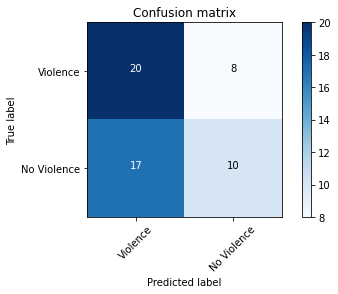

In [ ]:
plot_confusion_matrix(cm, classes=['Violence','No Violence']) 

In [ ]:
import sklearn 
from sklearn.metrics import confusion_matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
import scikitplot

In [ ]:
y_pred1 = model.predict(X_test) 
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred1, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")
 

IndentationError: ignored

In [ ]:

y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
#print(classification_report(y_test1, y_pred1))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


cm = confusion_matrix(y_test1, y_pred1)
cm_plot_labels = ['diseaseAffectedEggplant','freshEggplant']
figure = plot_confusion_matrix(cm,X_test,y_test,['s','sd'],normalize=True )
cm_image = plot_to_image(figure)

cm
 

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_plot_labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=include_values,
                 cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

plt.show()

NameError: ignored

KeyError: ignored

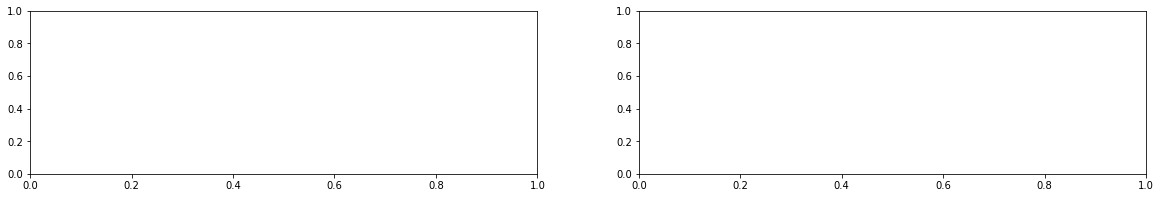

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))

## CONVLSTM2D

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 72, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(254, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))

In [ ]:
opt = SGD(lr=0.001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
#history = model.fit(x=X_train, y=y_train, epochs=25, batch_size = 5,shuffle = False, validation_split=0.1)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=5,
            epochs=25,
            verbose=1,
            validation_split=0.3)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 88, 88, 72)        194688    
_________________________________________________________________
dropout_2 (Dropout)          (None, 88, 88, 72)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 557568)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 254)               141622526 
_________________________________________________________________
dropout_3 (Dropout)          (None, 254)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 510       
Total params: 141,817,724
Trainable params: 141,817,724
Non-trainable params: 0
________________________________________

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.74      0.85      0.79        27

    accuracy                           0.78        55
   macro avg       0.79      0.78      0.78        55
weighted avg       0.79      0.78      0.78        55



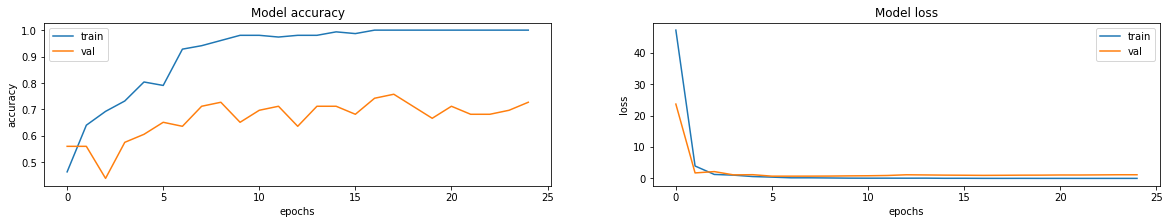

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))

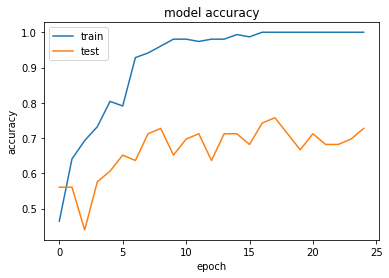

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

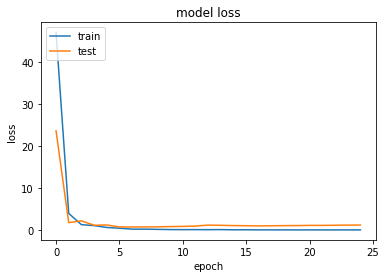

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.74      0.85      0.79        27

    accuracy                           0.78        55
   macro avg       0.79      0.78      0.78        55
weighted avg       0.79      0.78      0.78        55



In [ ]:
from sklearn.metrics import confusion_matrix
mypreds = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test1, mypreds)
print(cm)

[[21  7]
 [12 15]]


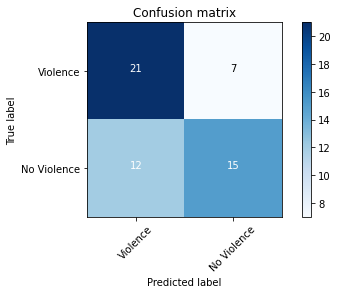

In [ ]:
plot_confusion_matrix(cm, classes=['Violence','No Violence']) 

In [ ]:
model.save('./predefence.h5')

In [ ]:
!pip3 install keras-visualizer

## 3D CNN+CONVLSTM

In [ ]:
model = Sequential()
model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(seq_len, img_height, img_width, 3)))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(layers.BatchNormalization(center=True, scale=True))
#model.add(layers.Dropout(0.5)) 
#model.add(layers.Flatten())

 
model.add(ConvLSTM2D(filters = 72, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(254, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=5,
            epochs=25,
            verbose=1,
            validation_split=0.3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 38, 88, 88, 32)    2624      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 19, 44, 44, 32)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 44, 44, 32)    128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 42, 42, 72)        269856    
_________________________________________________________________
dropout_8 (Dropout)          (None, 42, 42, 72)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 254)              

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        28
           1       0.58      0.52      0.55        27

    accuracy                           0.58        55
   macro avg       0.58      0.58      0.58        55
weighted avg       0.58      0.58      0.58        55



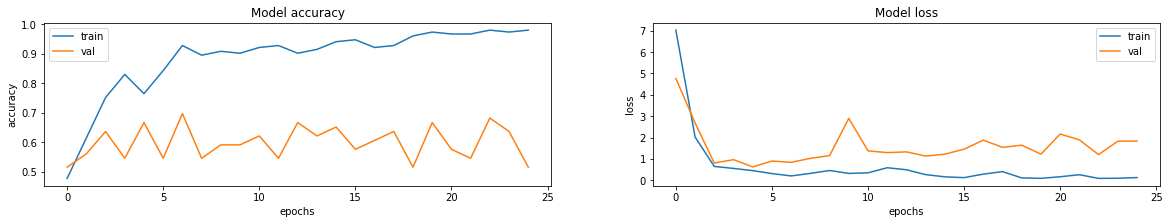

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))

## Firebase

In [ ]:
pip install git+https://github.com/ozgur/python-firebase

  Cloning https://github.com/ozgur/python-firebase to /tmp/pip-req-build-b8giuszw
  Running command git clone -q https://github.com/ozgur/python-firebase /tmp/pip-req-build-b8giuszw
  Created wheel for python-firebase: filename=python_firebase-1.2.1-cp37-none-any.whl size=12533 sha256=9aec6082656a11b935e67037eb0973dfb688b5ac80418c57875846d0c148c824
  Stored in directory: /tmp/pip-ephem-wheel-cache-ynuh181b/wheels/ef/40/57/99d925b3495995b9930edfb8f4033cb9a8dbf838848d5a65ba
Successfully built python-firebase


In [ ]:
credentials = "./ai-cctv-c37fe-default-rtdb-export.json"
img = "./output2.png"

In [ ]:
from firebase import firebase 
import os
credentials = "./ai-cctv-c37fe-default-rtdb-export.json"  #<add your credentials path>
#database
def violance(nf,lc,src):
  img = "./output2.png"
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credentials
  firebase1 = firebase.FirebaseApplication('https://ai-cctv-c37fe-default-rtdb.firebaseio.com/') #'<your firebase database path>'
  data={
      "Text": nf,
      "Location": lc,
      "Image":src
  }

  data2={"Test":"ok"}
  #res = firebase1.post("Violance",data) 
  res=firebase1.put("","Violance/Text",nf)
  firebase1.put("","Violance/Location", lc)
  firebase1.put("","Violance/Message",src)
 
  return res

In [ ]:
 #violance("Violance","Goplagnaj","test")

# Demo

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('./predefence.h5')

In [ ]:
video_path = './video_fight.mp4'
category =['NonViolence', 'Violence']
frames = []
frame_count = 0
queue=[]
cap = cv2.VideoCapture(video_path) # 0 for using webcam
while True:
    _,frame = cap.read()
    #cv2.imshow('Window',frame)
    frame = cv2.resize(frame, (90, 90))
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #faces = cascade.detectMultiScale(gray,1.1,3)
    
    #for x,y,w,h in faces:
        #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
    
    frame_count += 1
    frames.append(frame)

    if frame_count < 5:
        continue # capture frames until you get the required number for sequence
    else:
        frame_count = 0
    # For each frame, extract feature and prepare it for classification
    sequence = []
    for image in frames:
        sequence.append(image) 

    prediction = model.predict(np.expand_dims(sequence, axis=0))
    print(prediction)
    queue.append(prediction)
    results = np.array(queue).mean(axis=0)
    i = category[np.argmax(results)]
    print('Predicted: '+ i)
    
    if i=='Violence':
        #cv2.imshow('Window',frame)
        cv2.imwrite("output2.png",frame)
        violance("Violance","Goplagnaj","h")
        #plt.imshow("output2.png")
        break
    else:
        violance("No Violance","Goplagnaj","h")
    
        
    if cv2.waitKey(1)==ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

[[0.7280339 0.2719661]]
Predicted: NonViolence
[[0.01608301 0.98391706]]
Predicted: Violence


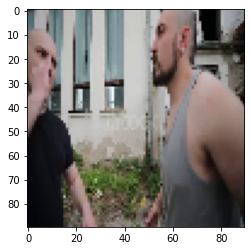

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("output2.png")
#print(img)
imgplot = plt.imshow(img)

In [ ]:
video_path = './nofight.mp4'
category =['NonViolence', 'Violence']
frames = []
frame_count = 0
queue=[]
cap = cv2.VideoCapture(video_path) # 0 for using webcam
while True:
    _,frame = cap.read()
    #cv2.imshow('Window',frame)
    frame = cv2.resize(frame, (90, 90))
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #faces = cascade.detectMultiScale(gray,1.1,3)
    
    #for x,y,w,h in faces:
        #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
    
    frame_count += 1
    frames.append(frame)

    if frame_count < 5:
        continue # capture frames until you get the required number for sequence
    else:
        frame_count = 0
    # For each frame, extract feature and prepare it for classification
    sequence = []
    for image in frames:
        sequence.append(image) 

    prediction = model.predict(np.expand_dims(sequence, axis=0))
    print(prediction)
    queue.append(prediction)
    results = np.array(queue).mean(axis=0)
    i = category[np.argmax(results)]
    print('Predicted: '+ i)
    
    if i=='Violence':
        #cv2.imshow('Window',frame)
        cv2.imwrite("output2.png",frame)
        violance("Violance","Goplagnaj","h")
        #plt.imshow("output2.png")
        break
    else:
        violance("No Violance","Goplagnaj","h")
    
        
    if cv2.waitKey(1)==ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

[[0.99566734 0.00433264]]
Predicted: NonViolence
[[0.971892   0.02810799]]
Predicted: NonViolence
[[0.9412605  0.05873951]]
Predicted: NonViolence
[[0.93256557 0.06743447]]
Predicted: NonViolence
[[0.8815898  0.11841018]]
Predicted: NonViolence
[[0.9313589  0.06864105]]
Predicted: NonViolence
[[0.9335066  0.06649334]]
Predicted: NonViolence
[[0.63468635 0.36531362]]
Predicted: NonViolence
[[0.8889165  0.11108352]]
Predicted: NonViolence
[[0.7320816 0.2679184]]
Predicted: NonViolence
[[0.5961254 0.4038746]]
Predicted: NonViolence
[[0.9383749  0.06162512]]
Predicted: NonViolence
[[0.806196   0.19380404]]
Predicted: NonViolence
[[0.6697428  0.33025718]]
Predicted: NonViolence
[[0.8214606  0.17853934]]
Predicted: NonViolence


error: ignored

# test

In [ ]:
data_dir = './datasets'
img_height , img_width = 150, 150
seq_len = 40
 
classes = ["noFight", "fight"]

In [ ]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list[:600]:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_dir)

fight
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
noFight
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame
Defected frame


In [ ]:
print(np.shape(X))
print(np.shape(Y))

(274, 40, 150, 150, 3)
(274, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters = 72, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(254, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=5,
            epochs=25,
            verbose=1,
            validation_split=0.3)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)
print(classification_report(y_test1, y_pred1))